### imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import sys

### get data

In [3]:
data = np.loadtxt(open("mnist_train_small.csv", "rb"), delimiter=",")

# shape of the data matrix
# print(data.shape)

# extract labels (number IDs) and remove from data
labels = data[:, 0]
data = data[:, 1:]

print(labels.shape)
print(data.shape)

(20000,)
(20000, 784)


### organize data

In [4]:
# normalize data
dataNorm = data / np.max(data)

# convert to tensor
dataTensor = torch.tensor(dataNorm, dtype=torch.float)
labelsTensor = torch.tensor(labels, dtype=torch.long)

# split into training and test set
train_data, test_data, train_labels, test_labels = train_test_split(
    dataTensor, labelsTensor, test_size=0.2, random_state=42
)

# convert to torch dataset and to dataloader
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

### ANN model

In [5]:
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(784, 128)
        self.hidden1 = nn.Linear(128, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 10)
        self.norm128 = nn.BatchNorm1d(128)
        self.norm264 = nn.BatchNorm1d(64)
        self.norm232 = nn.BatchNorm1d(32)
        self.dr = 0.3

    def forward(self, x):
        x = F.relu(self.input(x))
        x = self.norm128(x)
        x = F.dropout(x, p=self.dr, training=self.training)
        x = F.relu(self.hidden1(x))
        x = self.norm264(x)
        x = F.dropout(x, p=self.dr, training=self.training)
        x = F.relu(self.hidden2(x))
        x = self.norm232(x)
        x = F.dropout(x, p=self.dr, training=self.training)
        x = F.log_softmax(self.output(x), dim=1)
        return x

In [6]:
model = ANN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.NLLLoss()
print(model)

ANN(
  (input): Linear(in_features=784, out_features=128, bias=True)
  (hidden1): Linear(in_features=128, out_features=64, bias=True)
  (hidden2): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
  (norm128): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm264): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm232): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


### initial weights

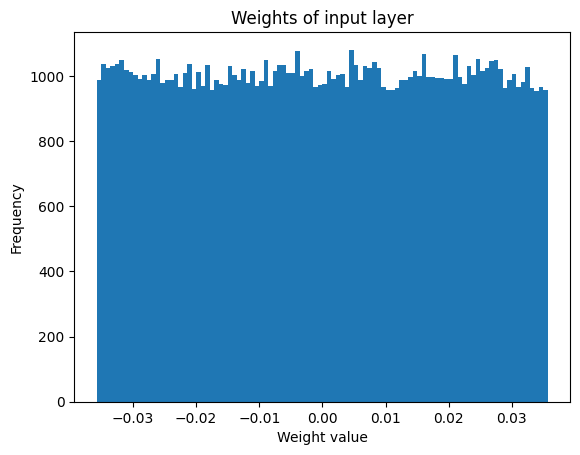

In [7]:
# plot as a histogram
w = model.input.weight.detach().numpy().flatten()
plt.hist(w, bins=100)
plt.title("Weights of input layer")
plt.xlabel("Weight value")
plt.ylabel("Frequency")
plt.show()

In [8]:
# get all weights and (x,y) for histogram
def get_weights(model):
    W = np.array([])
    for layer in [model.input, model.hidden1, model.hidden2, model.output]:
        W = np.concatenate((W, layer.weight.detach().numpy().flatten()))
    hist_y, hist_x = np.histogram(W, bins=np.linspace(-0.5, 0.5, 101), density=True)
    hist_x = (hist_x[1:] + hist_x[:-1]) / 2
    return hist_x, hist_y

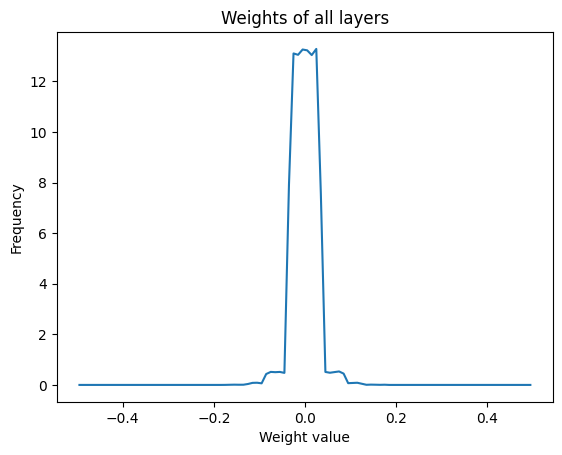

In [9]:
# plot the weights
wi_x, wi_y = get_weights(model)
plt.plot(wi_x, wi_y)
plt.title("Weights of all layers")
plt.xlabel("Weight value")
plt.ylabel("Frequency")
plt.show()

### training

In [10]:
# train the model
epochs = 50
losses = np.zeros(epochs)
trainAcc = np.zeros(epochs)
testAcc = np.zeros(epochs)
hists_x = np.zeros((epochs, 100))
hists_y = np.zeros((epochs, 100))

for i in range(epochs):
    model.train()
    batchAcc = []
    bactchLoss = []

    # get weights
    hists_x[i], hists_y[i] = get_weights(model)

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        batchAcc.append(
            100 * torch.mean((labels == torch.argmax(outputs, dim=1)).float())
        )
        bactchLoss.append(loss.item())
    losses[i] = np.mean(bactchLoss)
    trainAcc[i] = np.mean(batchAcc)

    # test model
    model.eval()
    x, y = next(iter(test_loader))
    with torch.no_grad():
        outputs = model(x)
        testAcc[i] = 100 * torch.mean((y == torch.argmax(outputs, dim=1)).float())

    msg = f"Epoch: {i+1}/{epochs}, Train acc: {trainAcc[i]:.2f}"
    sys.stdout.write("\r" + msg)

# approx runtime : 5 min

Epoch: 50/50, Train acc: 96.79

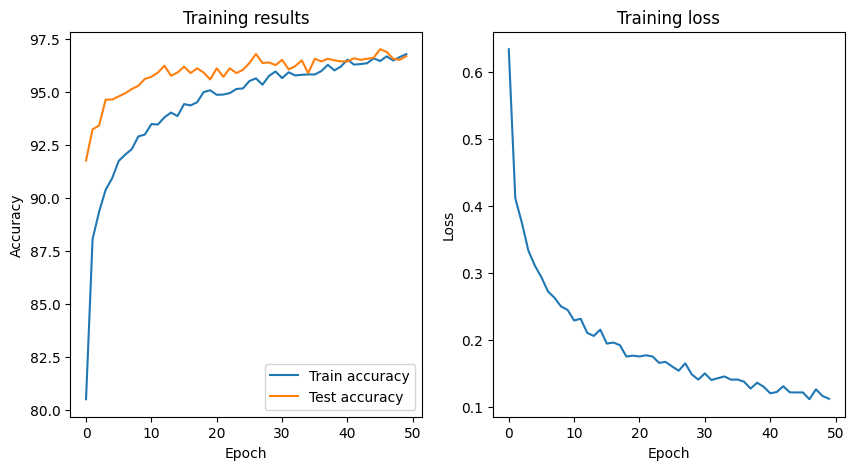

In [11]:
# plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(trainAcc, label="Train accuracy")
plt.plot(testAcc, label="Test accuracy")
plt.legend()
plt.title("Training results")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.subplot(1, 2, 2)
plt.plot(losses)
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### weights after training

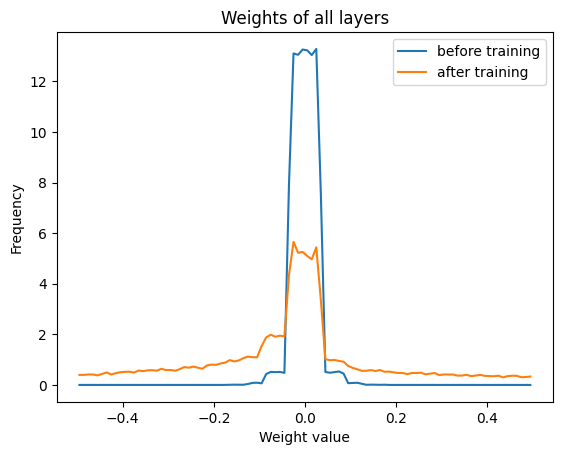

In [12]:
# plot the weights
wf_x, wf_y = get_weights(model)
plt.plot(wi_x, wi_y, label="before training")
plt.plot(wf_x, wf_y, label="after training")
plt.title("Weights of all layers")
plt.xlabel("Weight value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

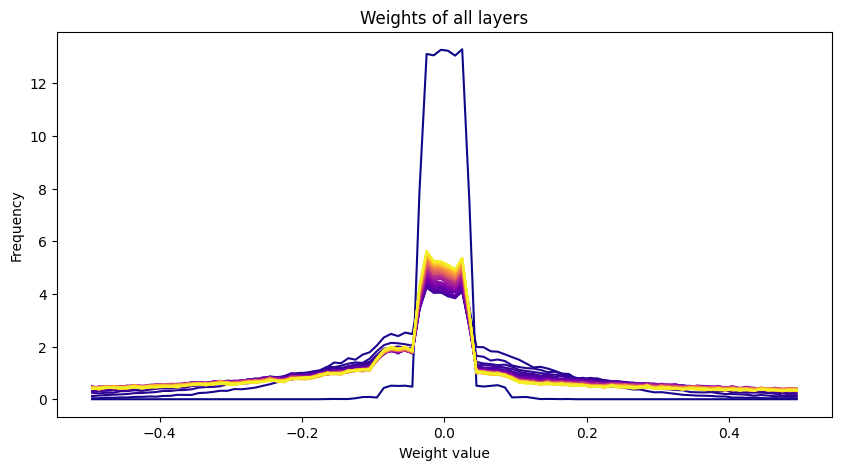

In [13]:
# plot the weights
plt.figure(figsize=(10, 5))
for i in range(epochs):
    plt.plot(hists_x[i], hists_y[i], color=plt.cm.plasma(i / epochs))
plt.title("Weights of all layers")
plt.xlabel("Weight value")
plt.ylabel("Frequency")
plt.show()
